In [59]:
from setup_notebook import set_path_to_root

import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns

from data.database import GrandExchangeDB

In [2]:
ge = GrandExchangeDB()

Local DB found, checking for updated data...
Progress 0/18
Progress 1/18
Progress 2/18
Progress 3/18
Progress 4/18
Progress 5/18
Progress 6/18
Progress 7/18
Progress 8/18
Progress 9/18
Progress 10/18
Progress 11/18
Progress 12/18
Progress 13/18
Progress 14/18
Progress 15/18
Progress 16/18
Progress 17/18
Latest price data loaded, 18 new timesteps saved


Select items which have on average more than 1m sold each hour

In [47]:
def load_price_data():
    prices = ge.query_db(
        """
        WITH ITEMS_TRADED AS (
        SELECT item_id
                ,AVG(avgHighPrice * highPriceVolume) as amnt_traded_high
        FROM PRICES
        WHERE avgHighPrice IS NOT NULL
        AND highPriceVolume IS NOT NULL
        GROUP BY item_id
        )
        SELECT PRICES.*
            ,ITEMS.name
        FROM PRICES 
        INNER JOIN (
            SELECT DISTINCT item_id
            FROM ITEMS_TRADED
            WHERE amnt_traded_high > 1e6
        ) as SELECTED_ITEMS
        ON PRICES.item_id = SELECTED_ITEMS.item_id
        LEFT JOIN ITEMS
        ON ITEMS.id = PRICES.item_id
        """
    ).drop('index', axis=1)

    # Keep only items which have records for 95% of the selected time period
    n_periods = prices['datetime'].nunique()
    df = prices[['item_id']].value_counts().reset_index(name='count')
    df = df.query(f'count >= {round(n_periods * 0.95)}')
    
    prices = prices[prices['item_id'].isin(df['item_id'])].copy()
    prices['item_id'] = prices['item_id'].astype(int)
    prices['datetime'] = pd.to_datetime(prices['datetime'])
    return prices

prices = load_price_data()

In [128]:
item_key = prices[['item_id', 'name', 'avgHighPrice', 'highPriceVolume']].copy()
item_key['high_amount'] = item_key['avgHighPrice'] * item_key['highPriceVolume']
item_key = item_key.groupby(['item_id', 'name'])['high_amount'].sum().reset_index()

In [118]:
def plot_single_item_prices(item_id):
    df = prices[prices['item_id'] == item_id].copy()
    item_name = df['name'].unique()[0] + ' prices'
    df = df[['datetime', 'avgHighPrice', 'avgLowPrice']]
    df = df.melt(id_vars='datetime')

    sns.set(rc={'figure.figsize':(15, 7)})
    ax = sns.lineplot(data=df, x='datetime', y='value', hue='variable')
    ax.set_title(item_name)
    plt.show()
    

def plot_single_item_margin(item_id):
    df = prices[prices['item_id'] == item_id].copy()
    item_name = df['name'].unique()[0] + ' margin'
    df['margin'] = df['avgHighPrice'] - df['avgLowPrice']
    sns.set(rc={'figure.figsize':(15, 7)})
    ax = sns.lineplot(data=df, x='datetime', y='margin')
    ax.set_title(item_name)
    plt.show()

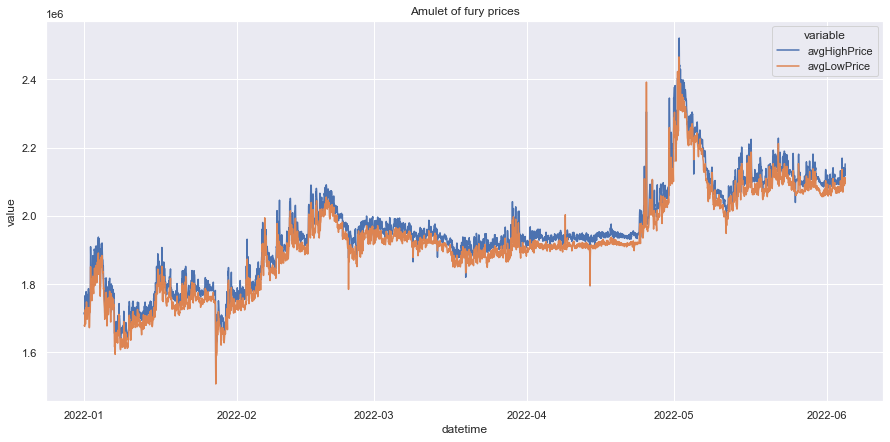

In [129]:
plot_single_item_prices(6585)

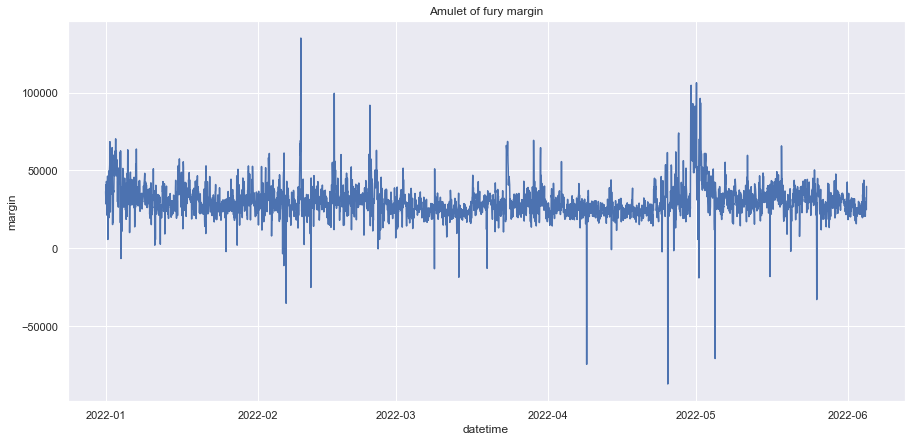

In [130]:
plot_single_item_margin(6585)

### More preprocessing
1. Remove outliers
1. Add a single price measure (mid-point?)

### Analysis

1. How many items?
1. Distribution of average prices (all items)
1. Distribution of variability (stddev)
1. Plots of margin against price over time
1. Ratio of price to amount traded (scatter)
